In [1]:
from sklearn.metrics import adjusted_mutual_info_score as AMI 
from sklearn.metrics import adjusted_rand_score as ARI
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
from collections import Counter
import pandas as pd
import numpy as np
import csv
from collections import Counter
from scipy.stats import binom 
from statistics import mean 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


In [2]:
## All functions here

# function for loading hnx HG from a file

def load_graph_from_file(filename):
    with open(filename,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))

    HG = hnx.Hypergraph(dict(enumerate(Edges)))
    #print(len(Edges), "edges")
    return HG


#modularity calculation (return mod, EC, and DT)

def new_modularity_details(H, A, wdc=hmod.linear):

    ## all same edge weights?
    uniq = (len(Counter(H.edges.properties['weight']))==1)
    
    ## Edge Contribution
    H_id = H.incidence_dict
    d = hmod.part2dict(A)
    L = [ [d[i] for i in H_id[x]] for x in H_id ]

    ## all same weight
    if uniq:
        _ctr = Counter([ (Counter(l).most_common(1)[0][1],len(l)) for l in L])
        EC = sum([wdc(k[1],k[0])*_ctr[k] for k in _ctr.keys() if k[0] > k[1]/2])
    else:
        _keys = [ (Counter(l).most_common(1)[0][1],len(l)) for l in L]
        _vals = list(H.edge_props['weight']) ## Thanks Brenda!!
        _df = pd.DataFrame(zip(_keys,_vals), columns=['key','val'])
        _df = _df.groupby(by='key').sum()
        EC = sum([ wdc(k[1],k[0])*v[0] for (k,v) in _df.iterrows() if k[0]>k[1]/2 ])
        
    ## Degree Tax
    if uniq:        
        VolA = [sum([H.degree(i) for i in k]) for k in A]
        Ctr = Counter([H.size(i) for i in H.edges])

    else:
        ## this is the bottleneck
        VolA = np.repeat(0,1+np.max(list(d.values())))
        m = np.max([H.size(i) for i in H.edges])
        Ctr = np.repeat(0,1+m)
        S = 0
        for e in H.edges:
            w = H.edges[e].weight
            Ctr[H.size(e)] += w  
            S += w
            for v in H.edges[e]:
                VolA[d[v]] += w 
                
    VolV = np.sum(VolA)
    VolA = [x/VolV for x in VolA]
    DT = 0
    
    if uniq:        
        for d in Ctr.keys():
            Cnt = Ctr[d]
            for c in np.arange(int(np.floor(d/2+1)),d+1):
                for Vol in VolA:
                    DT += (Cnt*wdc(d,c)*binom.pmf(c,d,Vol))
        return (EC-DT)/H.number_of_edges(), EC/H.number_of_edges(), DT/H.number_of_edges()
    else:
        for d in range(len(Ctr)):
            Cnt = Ctr[d]
            for c in np.arange(int(np.floor(d/2+1)),d+1):
                for Vol in VolA:
                    DT += (Cnt*wdc(d,c)*binom.pmf(c,d,Vol))
        return (EC-DT)/S, EC/S, DT/S

def getAMI_ARI(HG,gt,A):
    d = hmod.part2dict(A)
    A4ari = [d[str(i+1)] for i in range(len(HG.nodes))]
    return AMI(gt, A4ari), ARI(gt, A4ari)



#table with all stats

def create_table_with_stats(edge_file, H, gt, partitions, keys='all'):
    with open(edge_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))
    
    if keys == 'all':
        keys = partitions.keys()
    
    table = []
    for key in keys:
        A = partitions[key]
        table_row = {}
        table_row["partition"] = key
        table_row["#com"] = len(A)
        mod, ec, dt = new_modularity_details(H,A,wdc = hmod.linear)
        table_row["linear mod"] = mod
        table_row["linear mod EC"] = ec
        table_row["linear mod DT"] = dt
        mod, ec, dt = new_modularity_details(H,A,wdc = hmod.majority)
        table_row["majority mod"] = mod
        table_row["majority mod EC"] = ec
        table_row["majority mod DT"] = dt
        mod, ec, dt = new_modularity_details(H,A,wdc = hmod.strict)
        table_row["strict mod"] = mod
        table_row["strict mod EC"] = ec
        table_row["strict mod DT"] = dt
        ami, ari = getAMI_ARI(H,gt,A)
        table_row["AMI"] = ami
        table_row["ARI"] = ari

        d = hmod.part2dict(A)
        part = [d[str(i+1)] for i in range(len(H.nodes))]

        edge_comm_dict = []
        for e in Edges:
            size = len(e)
            biggest = Counter([part[int(i)-1] for i in e]).most_common(1)[0][1]
            edge_comm_dict.append({'size': size, 'biggest': biggest, 'ratio': biggest/size})
        ds = set([len(e) for e in Edges])

        for d in ds:
            table_row["#"+str(d)] = sum(list(a["size"]==d  for a in edge_comm_dict))
            total = sum(list(a["biggest"]>=int(np.floor(d/2+1)) and a["size"]==d  for a in edge_comm_dict))
            
            
            for c in np.arange(int(np.floor(d/2+1)),d+1):
                table_row["#("+str(c)+","+str(d)+")"] = sum(list(a["biggest"]==c and a["size"]==d  for a in edge_comm_dict))
            for c in np.arange(int(np.floor(d/2+1)),d+1):
                table_row["%("+str(c)+","+str(d)+")"] = sum(list(a["biggest"]==c and a["size"]==d  for a in edge_comm_dict))*100/total


        table.append(table_row)


    df = pd.json_normalize(table)
    return df



# Plots for h-ABCD with 4-6 edges

* Edge sizes: {5: 152, 6: 125, 4: 259}

In [3]:
edge_file = "datasets/results_300_4more_linear_252_he.txt"
comm_file = "datasets/results_300_4more_linear_252_assign.txt"
algorithm_partitions = pickle.load(open("pickles/abcdh-300-linear-1.p", "rb" ))
H = load_graph_from_file(edge_file)
with open(comm_file, 'r') as file:
    gt = [int(line) for line in file]
keys = ['gt','ML', 'KU', 'KU_nls_linear', 'KU_nls_majority', 'KU_nls_strict', 'hL linear v1', 
        'hL linear v1 + ls', 'hL linear v2', 'hL linear v2 + ls', 'hL majority v1', 'hL majority v1 + ls', 
        'hL majority v2', 'hL majority v2 + ls', 'hL strict v1', 'hL strict v1 + ls', 
        'hL strict v2', 'hL strict v2 + ls']
df = create_table_with_stats(edge_file, H, gt, algorithm_partitions, keys=keys)

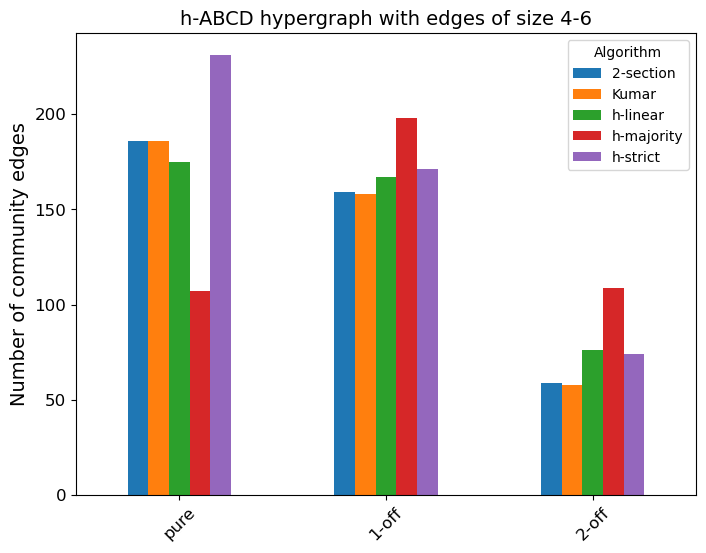

In [4]:
## 1. Type of edges recovered. We show:
# * the number of pure edges recovered in communities: (4,4), (5,5), (6,6) 
# * the 1-off: (3,4), (4,5), (5,6)
# * the 2-off: (3,5), (4,6)

df = create_table_with_stats(edge_file, H, gt, algorithm_partitions, keys=keys)

df['pure'] = df[['#(4,4)','#(5,5)','#(6,6)']].sum(axis=1)
df['1-off'] = df[['#(3,4)','#(4,5)','#(5,6)']].sum(axis=1)
df['2-off'] = df[['#(3,5)','#(4,6)']].sum(axis=1)
S = ['ML','KU','hL linear v1','hL majority v1','hL strict v1']
D = df[df['partition'].isin(S)]
D = D[['pure','1-off','2-off']]

fig, ax = plt.subplots()
D.transpose().plot(kind='bar',ax=ax, fontsize=12, rot=45, figsize=(8,6))
plt.ylabel('Number of community edges', fontsize=14)
plt.title('h-ABCD hypergraph with edges of size 4-6', fontsize=14)
ax.legend(['2-section','Kumar','h-linear','h-majority','h-strict'], title='Algorithm');
plt.savefig('ABCD-edges.png')

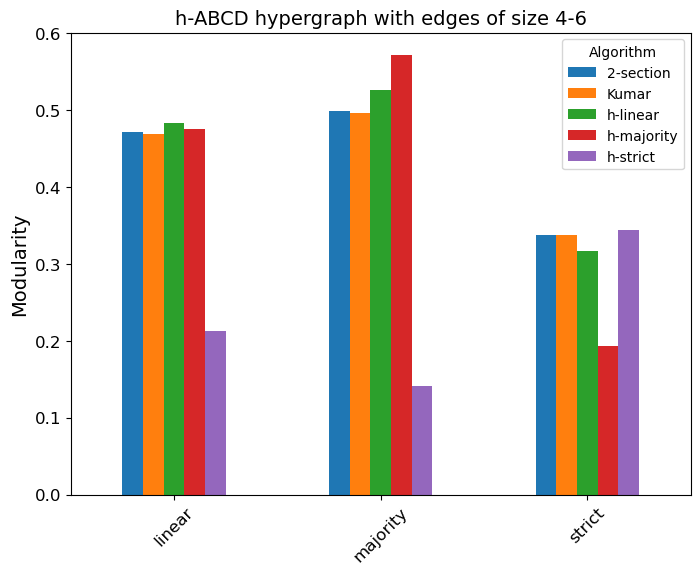

In [5]:
## 2. h-Modularities
# Results using various algorithms
S = ['ML','KU','hL linear v1','hL majority v1','hL strict v1']
D = df[df['partition'].isin(S)]
D = D[['linear mod','majority mod','strict mod']]
D = D.rename(columns={'linear mod':'linear','majority mod':'majority','strict mod':'strict'})

fig, ax = plt.subplots()
D.transpose().plot(kind='bar',ax=ax, fontsize=12, rot=45, figsize=(8,6))
plt.ylabel('Modularity', fontsize=14)
plt.title('h-ABCD hypergraph with edges of size 4-6', fontsize=14)
ax.legend(['2-section','Kumar','h-linear','h-majority','h-strict'], title='Algorithm');
plt.savefig('ABCD-modularities.png')

## Plots for Primary school contacts hypergraph

* Edge Sizes counter: {2: 7748, 3: 4600, 4: 347, 5: 9}
* Number of communities 11

In [6]:
edge_file = "datasets/hyperedges-contact-primary-school.txt"
comm_file = "datasets/node-labels-contact-primary-school.txt"
algorithm_partitions = pickle.load(open("pickles/primary-school-1.p", "rb" ))
H = load_graph_from_file(edge_file)
with open(comm_file, 'r') as file:
    gt = [int(line) for line in file]
keys = ['gt','ML', 'KU', 'KU_nls_linear', 'KU_nls_majority', 'KU_nls_strict', 'hL linear v1', 
        'hL linear v1 + ls', 'hL linear v2', 'hL linear v2 + ls', 'hL majority v1', 'hL majority v1 + ls', 
        'hL majority v2', 'hL majority v2 + ls', 'hL strict v1', 'hL strict v1 + ls', 
        'hL strict v2', 'hL strict v2 + ls']
df = create_table_with_stats(edge_file, H, gt, algorithm_partitions, keys=keys)

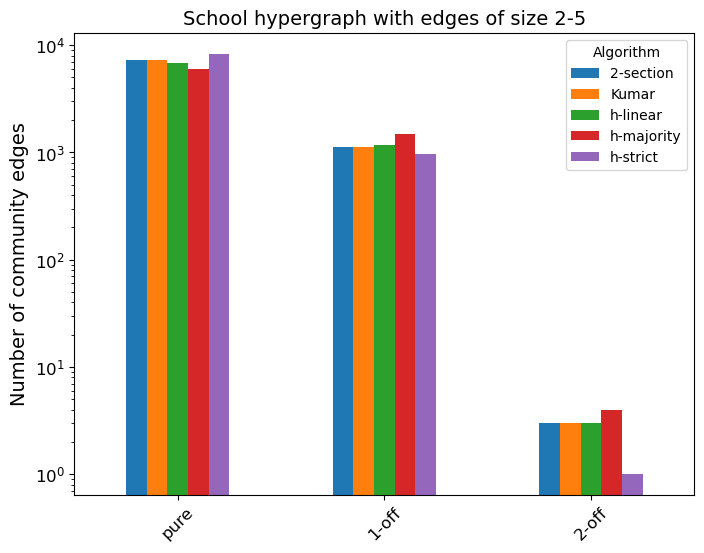

In [7]:
## 1. Type of edges recovered. We show:
# * the number of pure edges recovered in communities: (2,2), (3,3), (4,4), (5,5)
# * the 1-off: (2,3), (3,4), (4,5)
# * the 2-off: (3,5)
df['pure'] = df[['#(2,2)','#(3,3)','#(4,4)','#(5,5)']].sum(axis=1)
df['1-off'] = df[['#(2,3)','#(3,4)','#(4,5)']].sum(axis=1)
df['2-off'] = df[['#(3,5)']].sum(axis=1)
S = ['ML','KU','hL linear v1','hL majority v1','hL strict v1']
D = df[df['partition'].isin(S)]
D = D[['pure','1-off','2-off']]

fig, ax = plt.subplots()
D.transpose().plot(kind='bar',ax=ax, fontsize=12, rot=45, figsize=(8,6), logy=True)
plt.ylabel('Number of community edges', fontsize=14)
plt.title('School hypergraph with edges of size 2-5', fontsize=14)
ax.legend(['2-section','Kumar','h-linear','h-majority','h-strict'], title='Algorithm');
plt.savefig('school-edges.png')

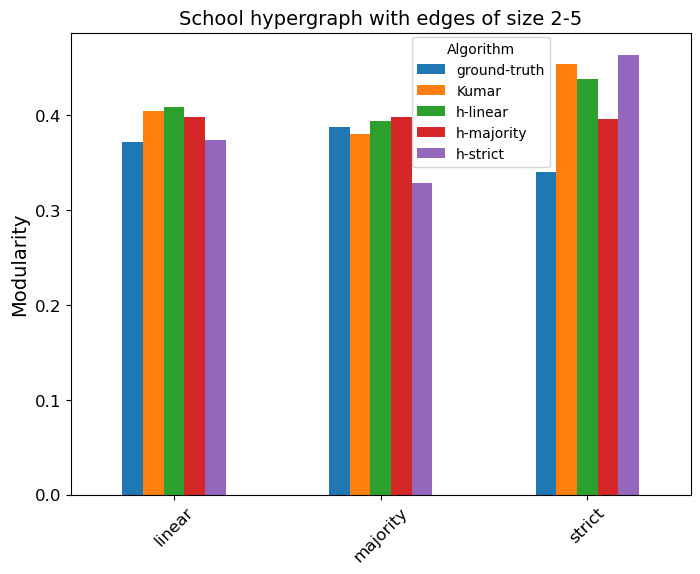

In [8]:
## 2. h-Modularities
# Results using various algorithms
# NB: here, Kumar == 2-section so we only show Kumar
S = ['gt','KU','hL linear v1','hL majority v1','hL strict v1']
D = df[df['partition'].isin(S)]
D = D[['linear mod','majority mod','strict mod']]
D = D.rename(columns={'linear mod':'linear','majority mod':'majority','strict mod':'strict'})

fig, ax = plt.subplots()
D.transpose().plot(kind='bar',ax=ax, fontsize=12, rot=45, figsize=(8,6))
plt.ylabel('Modularity', fontsize=14)
plt.title('School hypergraph with edges of size 2-5', fontsize=14)
ax.legend(['ground-truth','Kumar','h-linear','h-majority','h-strict'], title='Algorithm',loc=(.55,.71));
plt.savefig('school-modularities.png')

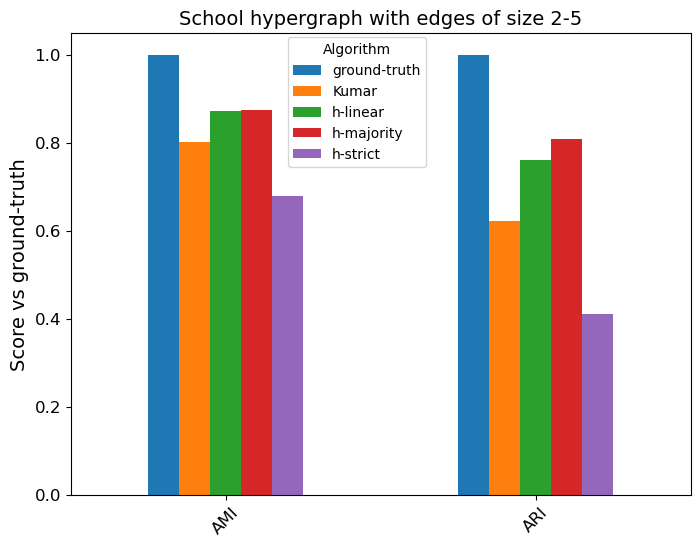

In [9]:
## 3. ARI and AMI
# Results using various algorithms
# NB: here, Kumar == 2-section so we only show Kumar
S = ['gt','KU','hL linear v1','hL majority v1','hL strict v1']
D = df[df['partition'].isin(S)]
D = D[['AMI','ARI']]

fig, ax = plt.subplots()
D.transpose().plot(kind='bar',ax=ax, fontsize=12, rot=45, figsize=(8,6))
plt.ylabel('Score vs ground-truth', fontsize=14)
plt.title('School hypergraph with edges of size 2-5', fontsize=14)
ax.legend(['ground-truth','Kumar','h-linear','h-majority','h-strict'], title='Algorithm',loc=(.35,.71));
plt.savefig('school-AMI.png')

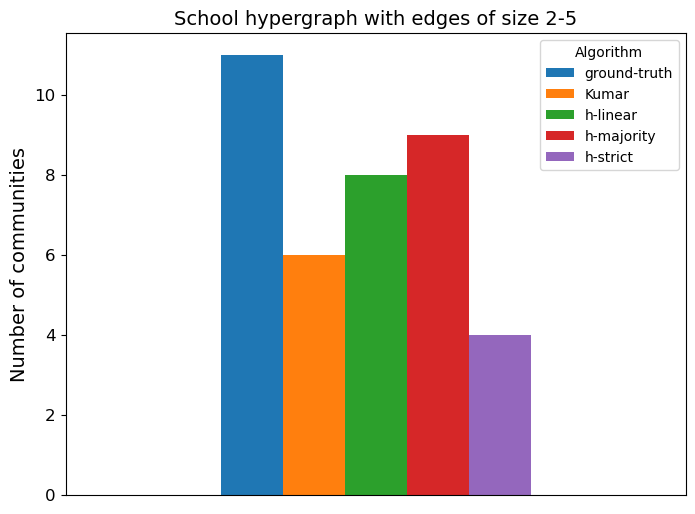

In [10]:
## 4. Number of communities found
# Results using various algorithms
# NB: here, Kumar == 2-section so we only show Kumar
S = ['gt','KU','hL linear v1','hL majority v1','hL strict v1']
D = df[df['partition'].isin(S)]
D = D[['#com']]

fig, ax = plt.subplots()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False  # labels along the bottom edge are off
)
D.transpose().plot(kind='bar',ax=ax, fontsize=12, rot=45, figsize=(8,6))
plt.ylabel('Number of communities', fontsize=14)
plt.title('School hypergraph with edges of size 2-5', fontsize=14)
ax.legend(['ground-truth','Kumar','h-linear','h-majority','h-strict'], title='Algorithm');
plt.savefig('school-comms.png')